# Using the Sample Representation Method GloScope

In this tutorial, we will demostrate how to use the reimplemented version of GloScope in `patpy` to build a sample representation from single-cell transcriptomics data.

Google Colab was utilized for the tutorial as this method needs a GPU.

## 1. Setup

### 1.1 Install the RAPIDS package

In [1]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

fatal: destination path 'rapidsai-csp-utils' already exists and is not an empty directory.
Installing RAPIDS remaining 25.08 libraries
Using Python 3.12.11 environment at: /usr
Audited 9 packages in 265ms

        ***********************************************************************
        The pip install of RAPIDS is complete.

        Please do not run any further installation from the conda based installation methods, as they may cause issues!

        Please ensure that you're pulling from the git repo to remain updated with the latest working install scripts.

        Troubleshooting:
            - If there is an installation failure, please check back on RAPIDSAI owned templates/notebooks to see how to update your personal files.
            - If an installation failure persists when using the latest script, please make an issue on https://github.com/rapidsai-community/rapidsai-csp-utils
        ***********************************************************************
        


In [2]:
import os
os.environ["SCIPY_ARRAY_API"] = "1"

### 1.2 Install the patpy package

This package contains the interface to sample representation methods as well as some handy analysis functions.

In [3]:
%cd patpy

/content/patpy


In [4]:
!pip install .

Processing /content/patpy
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for patpy: filename=patpy-0.10.0-py3-none-any.whl size=38527 sha256=cb57e5de7bcf4610c33fe83c99e5dcc0f7c111ab54e84dedcc0c89d54f22f60c
  Stored in directory: /tmp/pip-ephem-wheel-cache-79cq1c2y/wheels/c8/86/17/33134fde8cf340e8c9f976bb5b2bfb9b46f000a195ff8c7759
Successfully built patpy
  Attempting uninstall: patpy
    Found existing installation: patpy 0.10.0
    Uninstalling patpy-0.10.0:
      Successfully uninstalled patpy-0.10.0


### 1.3 Import packages

In [5]:
import pandas as pd
import numpy as np
import scanpy as sc
import patpy
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
patpy.__version__

'0.10.0'

## 2. Data Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### 2.1 Read the data

Here, we use [COMBAT dataset](https://www.kaggle.com/datasets/shitovvladimir/a-blood-atlas-of-covid-19-combat-preprocessed). This dataset contains 783k cells from 140 COVID-19 patients and healthy donors.

In [7]:
ADATA_PATH = "/content/drive/MyDrive/Uni/Master_Thesis/combat_processed_skinny.h5ad"

In [8]:
adata = sc.read_h5ad(ADATA_PATH)
adata

AnnData object with n_obs × n_vars = 783677 × 3000
    obs: 'Annotation_cluster_id', 'Annotation_cluster_name', 'Annotation_minor_subset', 'Annotation_major_subset', 'Annotation_cell_type', 'GEX_region', 'QC_ngenes', 'QC_total_UMI', 'QC_pct_mitochondrial', 'QC_scrub_doublet_scores', 'TCR_chain_composition', 'TCR_clone_ID', 'TCR_clone_count', 'TCR_clone_proportion', 'TCR_contains_unproductive', 'TCR_doublet', 'TCR_chain_TRA', 'TCR_v_gene_TRA', 'TCR_d_gene_TRA', 'TCR_j_gene_TRA', 'TCR_c_gene_TRA', 'TCR_productive_TRA', 'TCR_cdr3_TRA', 'TCR_umis_TRA', 'TCR_chain_TRA2', 'TCR_v_gene_TRA2', 'TCR_d_gene_TRA2', 'TCR_j_gene_TRA2', 'TCR_c_gene_TRA2', 'TCR_productive_TRA2', 'TCR_cdr3_TRA2', 'TCR_umis_TRA2', 'TCR_chain_TRB', 'TCR_v_gene_TRB', 'TCR_d_gene_TRB', 'TCR_j_gene_TRB', 'TCR_c_gene_TRB', 'TCR_productive_TRB', 'TCR_chain_TRB2', 'TCR_v_gene_TRB2', 'TCR_d_gene_TRB2', 'TCR_j_gene_TRB2', 'TCR_c_gene_TRB2', 'TCR_productive_TRB2', 'TCR_cdr3_TRB2', 'TCR_umis_TRB2', 'BCR_umis_HC', 'BCR_contig_qc_HC

### 2.2 Set columns containing sample IDs, cell types and metadata

In [9]:
sample_id_col = "scRNASeq_sample_ID"
cell_type_key = "cell_type"
samples_metadata_cols = ["Source", "Outcome", "Death28", "Hospitalstay", "TimeSinceOnset", "Institute", "Pool_ID",
                         "Age", "Sex", "BMI", "PreExistingHeartDisease", "PreExistingLungDisease", "PreExistingDiabetes",
                         "PreExistingHypertension", "Smoking", "Requiredvasoactive", "SARSCoV2PCR"]

samples_metadata_cols_plot = ["Source", "Outcome", "Death28", "Institute", "Pool_ID"]

Currently, there is no such columns as “cell_type” in the data. But cell types are stored in the `Annotation_major_subset` column. Let’s rename it to `cell_type` for better readability.

In [10]:
adata.obs.rename(columns={"Annotation_major_subset": cell_type_key}, inplace=True)

### 2.3 Store metadata and calculate QC metrics

In [11]:
metadata = adata.obs[samples_metadata_cols + [sample_id_col]].drop_duplicates()
metadata.set_index(sample_id_col, inplace=True)
metadata

,Source,Outcome,Death28,Hospitalstay,TimeSinceOnset,Institute,Pool_ID,Age,Sex,BMI,PreExistingHeartDisease,PreExistingLungDisease,PreExistingDiabetes,PreExistingHypertension,Smoking,Requiredvasoactive,SARSCoV2PCR
scRNASeq_sample_ID,,,,,,,,,,,,,,,,,
S00109-Ja001E-PBCa,COVID_SEV,2.0,0,1.0,12.0,Oxford,gPlexA,5.0,1,5,0.0,0.0,0.0,1.0,0,1.0,1
S00112-Ja003E-PBCa,COVID_MILD,5.0,0,2.0,12.0,Oxford,gPlexA,5.0,1,5,0.0,0.0,0.0,0.0,0,0.0,1
S00005-Ja005E-PBCa,COVID_CRIT,2.0,0,4.0,14.0,Oxford,gPlexA,7.0,0,1,1.0,0.0,0.0,1.0,0,1.0,1
S00061-Ja003E-PBCa,COVID_SEV,4.0,0,2.0,6.0,Oxford,gPlexA,5.0,1,5,0.0,0.0,0.0,0.0,0,0.0,1
S00056-Ja003E-PBCa,COVID_SEV,3.0,0,3.0,23.0,Oxford,gPlexA,7.0,0,5,0.0,0.0,0.0,0.0,0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S00065-Ja003E-PBCa,COVID_CRIT,2.0,0,3.0,16.0,Oxford,gPlexK,5.0,0,5,0.0,0.0,1.0,0.0,0,1.0,1
S00048-Ja003E-PBCa,COVID_SEV,4.0,0,2.0,12.0,Oxford,gPlexK,7.0,1,3,0.0,0.0,0.0,1.0,0,0.0,1
G05112-Ja005E-PBCa,COVID_HCW_MILD,6.0,0,NaN,7.0,Oxford,gPlexK,4.0,0,5,NaN,NaN,NaN,NaN,0,NaN,1


In [12]:
cell_qc_metadata = patpy.pp.calculate_cell_qc_metrics(
    adata, sample_key=sample_id_col, cell_qc_vars=["QC_ngenes", "QC_total_UMI", "QC_pct_mitochondrial"]
)
cell_qc_metadata.columns = ["median_n_genes_by_counts", "median_total_counts", "median_pct_counts_mt"]
cell_qc_metadata

/usr/local/lib/python3.12/dist-packages/patpy/pp/basic.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  metadata = adata.obs[[sample_key, *cell_qc_vars]].groupby(by=sample_key)
/usr/local/lib/python3.12/dist-packages/patpy/pp/basic.py:180: FutureWarning: The provided callable <function median at 0x7a555677bba0> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  cells_qc_aggregated = metadata.aggregate(agg_function)


,median_n_genes_by_counts,median_total_counts,median_pct_counts_mt
scRNASeq_sample_ID,,,
G05061-Ja005E-PBCa,1107.0,3125.5,3.011159
G05064-Ja005E-PBCa,975.0,2933.0,1.332430
G05073-Ja005E-PBCa,1141.0,3554.0,2.422559
G05077-Ja005E-PBCa,1125.0,3268.0,2.946723
G05078-Ja005E-PBCa,999.0,3106.0,2.825308
...,...,...,...
U00607-Ua005E-PBUa,1827.0,5749.0,2.982509
U00613-Ua005E-PBUa,1251.5,3325.0,2.053083
U00617-Ua005E-PBUa,1410.5,4524.0,3.886215


In [13]:
n_genes_metadata = patpy.pp.calculate_n_cells_per_sample(adata, sample_id_col)
n_genes_metadata

,n_cells
scRNASeq_sample_ID,
S00052-Ja005E-PBCa,13918
H00054-Ha001E-PBGa,10938
H00067-Ha001E-PBGa,10781
N00023-Ja001E-PBGa,10484
H00053-Ha001E-PBGa,10458
...,...
U00607-Ua005E-PBUa,1021
U00613-Ua005E-PBUa,970
U00701-Ua005E-PBUa,872


In [14]:
composition_metadata = patpy.pp.calculate_compositional_metrics(adata, sample_id_col, [cell_type_key], normalize_to=100)
composition_metadata

cell_type,cell_type_B,cell_type_CD4,cell_type_CD8,cell_type_DC,cell_type_DN,cell_type_DP,cell_type_GDT,cell_type_HSC,cell_type_MAIT,cell_type_Mast,cell_type_NK,cell_type_PB,cell_type_PLT,cell_type_RET,cell_type_cMono,cell_type_iNKT,cell_type_ncMono
scRNASeq_sample_ID,,,,,,,,,,,,,,,,,
G05061-Ja005E-PBCa,6.324900,33.921438,12.366844,1.597870,0.532623,0.499334,0.898802,0.066578,4.677097,0.000000,18.159121,0.316245,0.166445,0.016644,15.812250,0.033289,4.610519
G05064-Ja005E-PBCa,3.405158,47.147482,16.400581,1.819806,1.228090,0.725689,2.188233,0.022329,1.317405,0.000000,7.457854,0.446578,0.000000,0.000000,14.357486,0.000000,3.483309
G05073-Ja005E-PBCa,5.194338,45.609405,16.278791,1.487524,1.247601,0.839731,4.654511,0.011996,2.195298,0.011996,3.730806,0.203935,0.047985,0.000000,13.963532,0.083973,4.438580
G05077-Ja005E-PBCa,5.846211,29.231056,14.596909,1.377770,0.446844,1.340532,0.465463,0.167567,0.800596,0.018619,22.844908,1.079873,0.074474,0.018619,18.004096,0.055856,3.630609
G05078-Ja005E-PBCa,1.366381,39.000106,15.591569,2.340854,0.762631,0.730855,2.648025,0.211842,1.737104,0.021184,10.666243,0.148289,0.021184,0.000000,19.521237,0.497829,4.734668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
U00607-Ua005E-PBUa,3.623898,10.577865,1.273262,4.701273,0.097943,0.195886,0.195886,0.685602,0.097943,0.000000,5.876592,1.175318,1.958864,0.097943,37.904016,0.000000,31.537708
U00613-Ua005E-PBUa,7.835052,26.391753,16.907216,0.721649,0.412371,0.309278,1.649485,0.000000,0.103093,0.000000,5.154639,1.237113,0.206186,0.000000,37.938144,0.000000,1.134021
U00617-Ua005E-PBUa,2.977233,41.418564,16.462347,0.437828,0.525394,0.262697,0.262697,0.963222,0.087566,0.000000,7.530648,17.513135,0.788091,0.087566,9.719790,0.000000,0.963222


Add the additional meta data to the AnnData object:

In [15]:
metadata = pd.concat(
    [
        metadata,
        cell_qc_metadata.loc[metadata.index],
        n_genes_metadata.loc[metadata.index],
        composition_metadata.loc[metadata.index],
    ],
    axis=1,
)

metadata.shape

(138, 38)

### 2.4 Quality control

To reduce noise in the representations, we need to remove samples with too few cells:

In [16]:
adata = patpy.pp.filter_small_samples(adata, sample_key=sample_id_col, sample_size_threshold=100)

0 samples removed: 


## 3. Original GloScope Implementation

This version is [implemented in R](https://www.bioconductor.org/packages/release/bioc/html/GloScope.html) and can be used via patpy.

### 3.1 Prepare a smaller data set

The COMBAT data set consists of 140 samples (138 after quality control) and 783.704 cells. This subset is equivalent to ~8% of the original data set.

In [ ]:
np.random.seed(42)

# Choose 10 random samples from the AnnData object
random_samples = np.random.choice(adata.obs['scRNASeq_sample_ID'].unique(), size=10, replace=False)

# Create subset using the random samples
adata_subset = adata[adata.obs['scRNASeq_sample_ID'].isin(random_samples)].copy()
adata_subset

AnnData object with n_obs × n_vars = 59868 × 3000
    obs: 'Annotation_cluster_id', 'Annotation_cluster_name', 'Annotation_minor_subset', 'cell_type', 'Annotation_cell_type', 'GEX_region', 'QC_ngenes', 'QC_total_UMI', 'QC_pct_mitochondrial', 'QC_scrub_doublet_scores', 'TCR_chain_composition', 'TCR_clone_ID', 'TCR_clone_count', 'TCR_clone_proportion', 'TCR_contains_unproductive', 'TCR_doublet', 'TCR_chain_TRA', 'TCR_v_gene_TRA', 'TCR_d_gene_TRA', 'TCR_j_gene_TRA', 'TCR_c_gene_TRA', 'TCR_productive_TRA', 'TCR_cdr3_TRA', 'TCR_umis_TRA', 'TCR_chain_TRA2', 'TCR_v_gene_TRA2', 'TCR_d_gene_TRA2', 'TCR_j_gene_TRA2', 'TCR_c_gene_TRA2', 'TCR_productive_TRA2', 'TCR_cdr3_TRA2', 'TCR_umis_TRA2', 'TCR_chain_TRB', 'TCR_v_gene_TRB', 'TCR_d_gene_TRB', 'TCR_j_gene_TRB', 'TCR_c_gene_TRB', 'TCR_productive_TRB', 'TCR_chain_TRB2', 'TCR_v_gene_TRB2', 'TCR_d_gene_TRB2', 'TCR_j_gene_TRB2', 'TCR_c_gene_TRB2', 'TCR_productive_TRB2', 'TCR_cdr3_TRB2', 'TCR_umis_TRB2', 'BCR_umis_HC', 'BCR_contig_qc_HC', 'BCR_functio

### 3.2 Run the GloScope representation

In [ ]:
gloscope_r = patpy.tl.GloScope(sample_key=sample_id_col, layer="X_pca", k=25)
gloscope_r.prepare_anndata(adata_subset)

Error importing in API mode: ImportError("dlopen(/Users/emmaschonner/miniforge3/envs/gloscope/lib/python3.13/site-packages/_rinterface_cffi_api.abi3.so, 0x0002): symbol not found in flat namespace '_R_BaseEnv'")
Trying to import in ABI mode.
/Users/emmaschonner/miniforge3/envs/gloscope/lib/python3.13/site-packages/rpy2/rinterface/__init__.py:1211: UserWarning: Environment variable "XPC_SERVICE_NAME" redefined by R and overriding existing variable. Current: "application.com.microsoft.VSCode.100230723.100230729", R: "0"
  warnings.warn(
/Users/emmaschonner/miniforge3/envs/gloscope/lib/python3.13/site-packages/rpy2/rinterface/__init__.py:1211: UserWarning: Environment variable "R_SESSION_TMPDIR" redefined by R and overriding existing variable. Current: "/var/folders/z_/nw0n7j9917b1t955zn7rj2vc0000gn/T//RtmpbHjNYf", R: "/var/folders/z_/nw0n7j9917b1t955zn7rj2vc0000gn/T//RtmpiK8AkD"
  warnings.warn(


### 3.3 Calculate the distance matrix between samples

In [ ]:
import time

t_start = time.time()
distances_r = gloscope_r.calculate_distance_matrix(force=True)
t_end = time.time()

distances_r

/Users/emmaschonner/PycharmProjects/patpy/src/patpy/tl/sample_representation.py:453: UserWarning: Using data from key X_pca of adata.obsm
  warnings.warn(f"Using data from key {self.layer} of adata.obsm", stacklevel=1)


Calculating GloScope distance matrix


array([[ 0.        , 21.79973998, 55.60177846, 23.11245485, 18.85791765,
        24.20963162, 21.66354725, 15.0275896 , 29.69130078, 22.8982986 ],
       [21.79973998,  0.        , 40.20559976, 14.95373385, 12.10770659,
        28.13805089, 22.538651  , 26.98556906, 21.91952643, 17.26786574],
       [55.60177846, 40.20559976,  0.        , 47.6915646 , 44.44007074,
        60.23833798, 51.87250821, 55.68284049, 28.35562453, 50.146914  ],
       [23.11245485, 14.95373385, 47.6915646 ,  0.        , 14.82702289,
        21.43215665, 14.06787361, 22.44525337, 24.69353425,  5.98674642],
       [18.85791765, 12.10770659, 44.44007074, 14.82702289,  0.        ,
        27.54803131, 14.73536607, 18.91967826, 16.03847056, 16.2264228 ],
       [24.20963162, 28.13805089, 60.23833798, 21.43215665, 27.54803131,
         0.        , 23.79251528, 21.44611482, 37.65964936, 19.40774581],
       [21.66354725, 22.538651  , 51.87250821, 14.06787361, 14.73536607,
        23.79251528,  0.        , 14.05139714

This implementation of GloScope takes almost 6 minutes for a small subset of the COMBAT data set. Using this method for larger data sets is not feasible.

In [ ]:
round((t_end - t_start) / 60, 2)

6.06

## 4. Reimplemenation in Python

The nearest neighbor computation for the distance matrix calculation can either be done using a CPU or a GPU. By setting the parameter `use_gpu=True` the matrix will be calculated using [cuML](https://docs.rapids.ai/api/cuml/stable/), otherwise [PyNNDescent](https://pynndescent.readthedocs.io/en/stable/index.html) is utilized.

### 4.1 Run the GloScope representation

In [17]:
gloscope_py = patpy.tl.GloScope_py(sample_key=sample_id_col, layer="X_pca", k=25, use_gpu=True)
gloscope_py.prepare_anndata(adata)

### 4.2 Calculate the distance matrix between samples

In [18]:
distances_py = gloscope_py.calculate_distance_matrix(force=True)
distances_py

array([[ 0.        ,  7.15476107,  8.42393753, ...,  6.50869307,
        10.64266584, 10.55392553],
       [ 7.15476107,  0.        ,  3.85350657, ..., 10.71247543,
        10.69340206,  6.40234264],
       [ 8.42393753,  3.85350657,  0.        , ..., 13.76320563,
        11.24252866,  3.67902335],
       ...,
       [ 6.50869307, 10.71247543, 13.76320563, ...,  0.        ,
         9.09696113, 13.3028802 ],
       [10.64266584, 10.69340206, 11.24252866, ...,  9.09696113,
         0.        ,  8.85906771],
       [10.55392553,  6.40234264,  3.67902335, ..., 13.3028802 ,
         8.85906771,  0.        ]])

Then new implementation only takes about two minutes for the whole COMBAT data set (without GPU).

### 4.3 Visualize the sample representation using dimensionality reduction methods

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


array([<Axes: xlabel='UMAP_0', ylabel='UMAP_1'>,
       <Axes: xlabel='UMAP_0', ylabel='UMAP_1'>,
       <Axes: xlabel='UMAP_0', ylabel='UMAP_1'>,
       <Axes: xlabel='UMAP_0', ylabel='UMAP_1'>,
       <Axes: xlabel='UMAP_0', ylabel='UMAP_1'>], dtype=object)

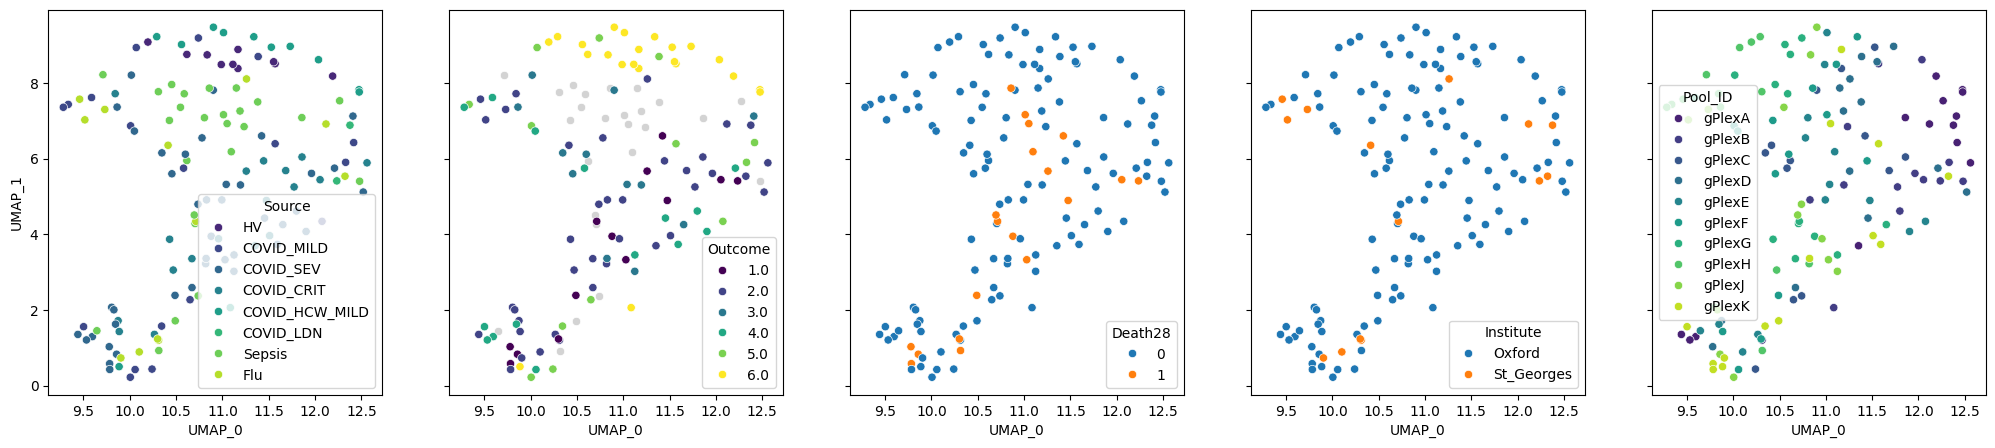

In [19]:
gloscope_py.plot_embedding(method="UMAP", metadata_cols=samples_metadata_cols_plot)

### 4.4 Save the distances

In [20]:
adata.uns["gloscope_py_distances"] = distances_py
adata.uns["gloscope_py_samples"] = gloscope_py.samples
adata.uns["gloscope_py_UMAP"] = gloscope_py.embeddings["UMAP"]

## 5. Benchmarking of the Reimplementation

The top level keys categorize the features into types: relevant features which we want to represent better, technical ones that we want to mix and contextual features that are not that important.

The subdictionaries consist of metadata columns as keys and evaluation tasks as values.

In [22]:
benchmark_schema = {
    "Relevant": {
        "Source": "classification",
        "Outcome": "ranking",
        "Death28": "classification",
        "Hospitalstay": "regression",
        "TimeSinceOnset": "regression"
    },
    "Technical": {
        "Institute": "classification",
        "Pool_ID": "classification",
        "median_n_genes_by_counts": "regression",
        "median_total_counts": "regression",
        "median_pct_counts_mt": "regression",
        "n_cells": "regression"
    },
    "Contextual": {
        "Age": "regression",
        "Sex": "classification",
        "BMI": "regression",
        "PreExistingHeartDisease": "classification",
        "PreExistingLungDisease": "classification",
        "PreExistingDiabetes": "classification",
        "PreExistingHypertension": "classification",
        "Smoking": "classification",
        "Requiredvasoactive": "classification",
        "SARSCoV2PCR": "classification"
    }
}

### 5.1 Run the benchmark

In [23]:
metadata = metadata.loc[adata.obs[sample_id_col].unique()]

In [24]:
results = []

for type_name, type_data in benchmark_schema.items():
    for target, task in type_data.items():
        result = patpy.tl.evaluate_representation(
                    distances=adata.uns["gloscope_py_distances"],
                    target=metadata[target],
                    method="knn",
                    task=task,
                    n_neighbors=5
                )

        result["covariate"] = target
        result["covariate_type"] = type_name

        if result["metric"] == "spearman_r":
            result["score"] = abs(result["score"])

        if type_name == "technical":
            result["score"] = 1 - result["score"]

        results.append(result)

In [25]:
knn_results = pd.DataFrame(results)
knn_results.sort_values(by="score", ascending=False)

,score,metric,n_unique,n_observations,method,covariate,covariate_type
9,0.879248,spearman_r,138,138,knn,median_pct_counts_mt,Technical
7,0.787438,spearman_r,119,138,knn,median_n_genes_by_counts,Technical
1,0.714493,spearman_r,6,113,knn,Outcome,Relevant
8,0.687307,spearman_r,132,138,knn,median_total_counts,Technical
20,0.505672,f1_macro_calibrated,2,138,knn,SARSCoV2PCR,Contextual
10,0.406396,spearman_r,138,138,knn,n_cells,Technical
15,0.350820,f1_macro_calibrated,2,99,knn,PreExistingLungDisease,Contextual
6,0.270655,f1_macro_calibrated,10,138,knn,Pool_ID,Technical
4,0.268094,spearman_r,26,128,knn,TimeSinceOnset,Relevant
0,0.257086,f1_macro_calibrated,8,138,knn,Source,Relevant


### 5.2 Visualize the results

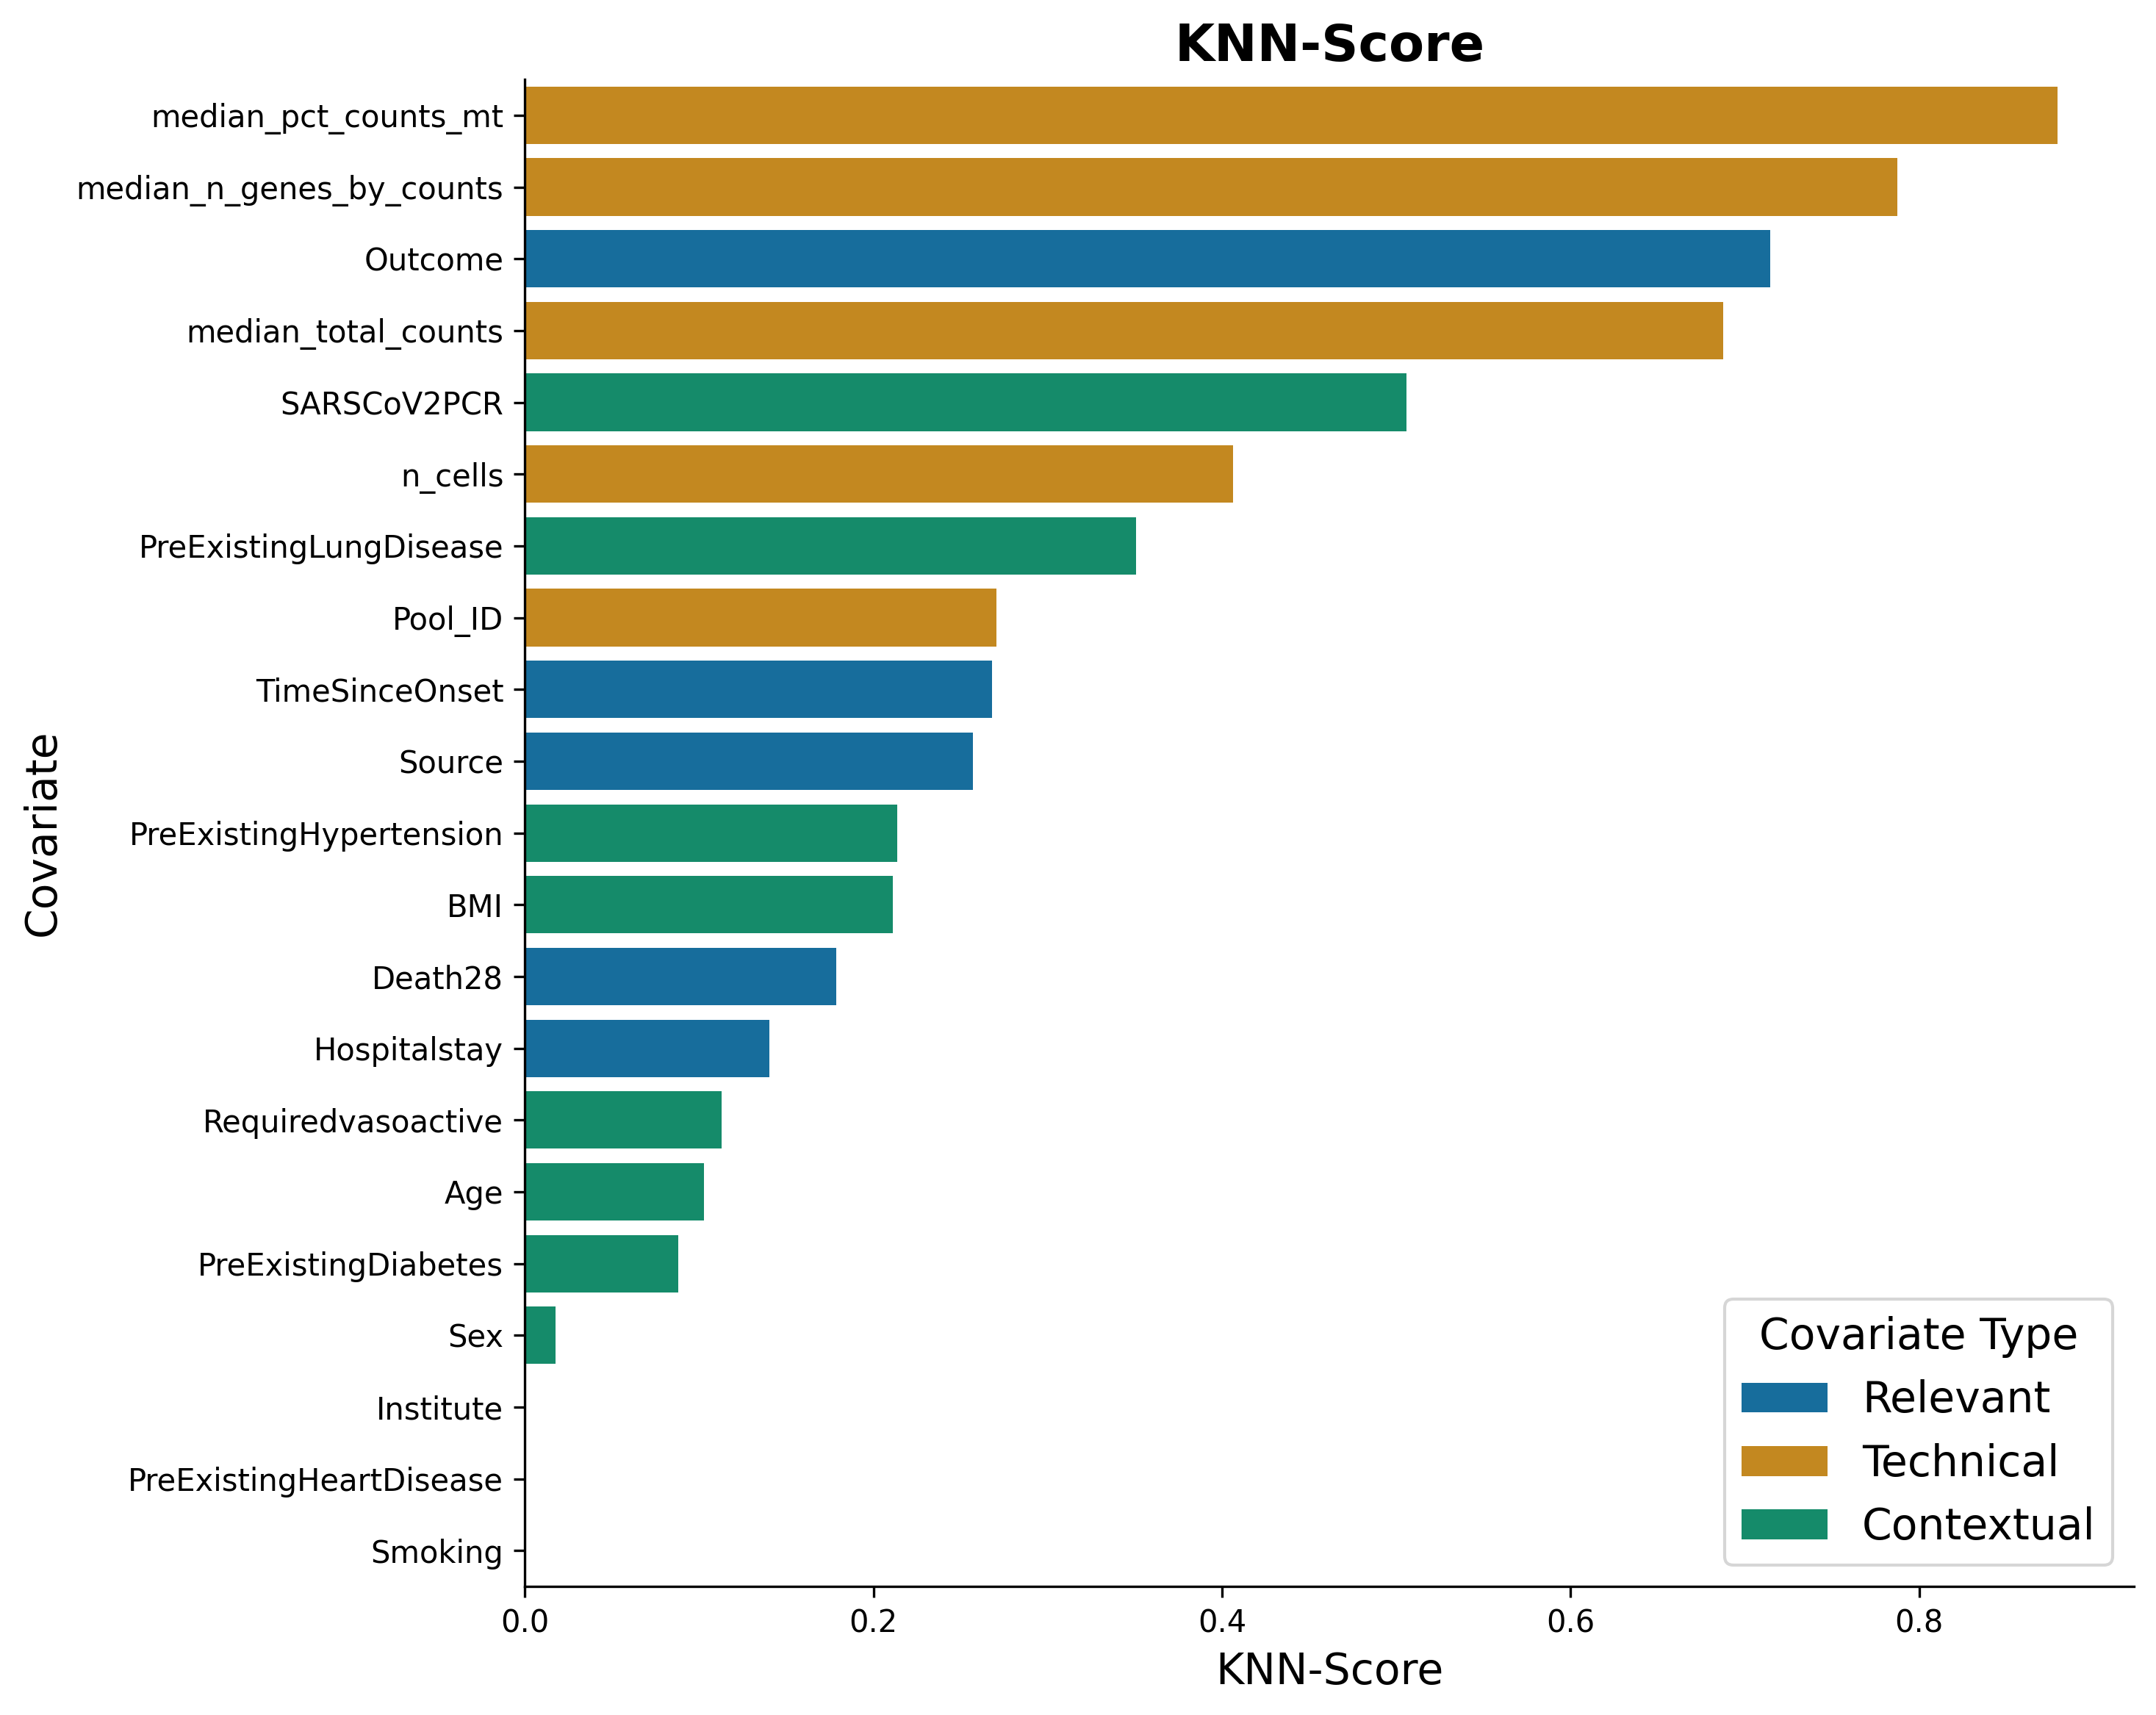

In [26]:
plt.figure(figsize=(10, 8), dpi=300)
plt.rcParams.update({
    'font.size': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})

sns.barplot(
    data=knn_results,
    y="covariate",
    x="score",
    hue="covariate_type",
    dodge=False,
    palette="colorblind",
    order=knn_results.sort_values('score', ascending = False).covariate
)

plt.xlabel("KNN-Score")
plt.ylabel("Covariate")

plt.legend(title="Covariate Type")
plt.title("KNN-Score", fontweight='bold')

sns.despine()
plt.tight_layout()
plt.show()

### 5.3 Have a further look at *Institute*, *PreExistingHeartDisease* and *Smoking*

In [27]:
adata.obs[['scRNASeq_sample_ID', 'Institute']].drop_duplicates()['Institute'].value_counts()

,count
Institute,
Oxford,124
St_Georges,14


In [28]:
# Only 99 patients have data
adata.obs[['scRNASeq_sample_ID', 'PreExistingHeartDisease']].drop_duplicates()['PreExistingHeartDisease'].value_counts()

,count
PreExistingHeartDisease,
0.0,89
1.0,10


In [29]:
adata.obs[['scRNASeq_sample_ID', 'Smoking']].drop_duplicates()['Smoking'].value_counts()

,count
Smoking,
0,100
1,30
2,8


array([<Axes: xlabel='UMAP_0', ylabel='UMAP_1'>,
       <Axes: xlabel='UMAP_0', ylabel='UMAP_1'>,
       <Axes: xlabel='UMAP_0', ylabel='UMAP_1'>], dtype=object)

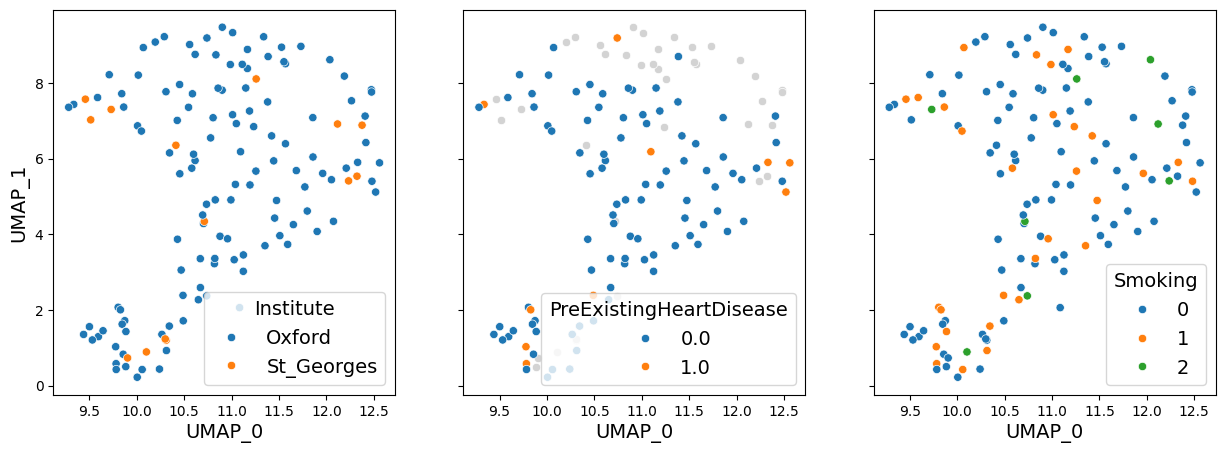

In [30]:
gloscope_py.plot_embedding(method="UMAP", metadata_cols=['Institute', 'PreExistingHeartDisease', 'Smoking'])